In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Image, clear_output 
import time
import json 
import random

In [2]:
# Load camera parameters from Part 1 (copied from user request)
final_camera_parameters = {
    'focal_length_x': 1029.363321844588,
    'focal_length_y': 1029.363321844588,
    'principal_point_x': 480.0,
    'principal_point_y': 360.0,
    'distortion_coeffs': [0.0, 0.0, 0.0, 0.0, 0.0], # Represented as list
    'vanishing_point': (1015.65, 154.78),
    'camera_height_pixels': 235.22,
    'pixel_distance_at_reference': 491.81818181818176,
    'reference_y': 390,
    'known_distance_meters': 3.5,
    'image_width': 960,
    'image_height': 720
}

print("Camera Parameters Loaded:")
# Pretty print the dictionary
print(json.dumps(final_camera_parameters, indent=4))

# Define video path from Part 1
video_path = './input_videos/cars_road_3.mp4'
output_video_path = './output_videos/part3_detections.mp4'
output_detections_path = './output_data/part3_detections.json'

# Create output directories if they don't exist
os.makedirs(os.path.dirname(output_video_path), exist_ok=True)
os.makedirs(os.path.dirname(output_detections_path), exist_ok=True)

print(f"Input video: {video_path}")
print(f"Output video will be saved to: {output_video_path}")
print(f"Detections data will be saved to: {output_detections_path}")

Camera Parameters Loaded:
{
    "focal_length_x": 1029.363321844588,
    "focal_length_y": 1029.363321844588,
    "principal_point_x": 480.0,
    "principal_point_y": 360.0,
    "distortion_coeffs": [
        0.0,
        0.0,
        0.0,
        0.0,
        0.0
    ],
    "vanishing_point": [
        1015.65,
        154.78
    ],
    "camera_height_pixels": 235.22,
    "pixel_distance_at_reference": 491.81818181818176,
    "reference_y": 390,
    "known_distance_meters": 3.5,
    "image_width": 960,
    "image_height": 720
}
Input video: ./input_videos/cars_road_3.mp4
Output video will be saved to: ./output_videos/part3_detections.mp4
Detections data will be saved to: ./output_data/part3_detections.json


## Detection
detecting vehciles inside a pre-defined ROI using the Yolo model. saving the boudning boxes

In [25]:
# Define ROI filtering function
def is_in_roi(bbox, roi_polygon):
    # Get center point of bbox
    center_x = (bbox[0] + bbox[2]) / 2
    center_y = (bbox[3]) # Use bottom of box (where it touches the road)
    center_point = (center_x, center_y)
    
    # Check if point is inside polygon
    return cv2.pointPolygonTest(roi_polygon, center_point, False) >= 0

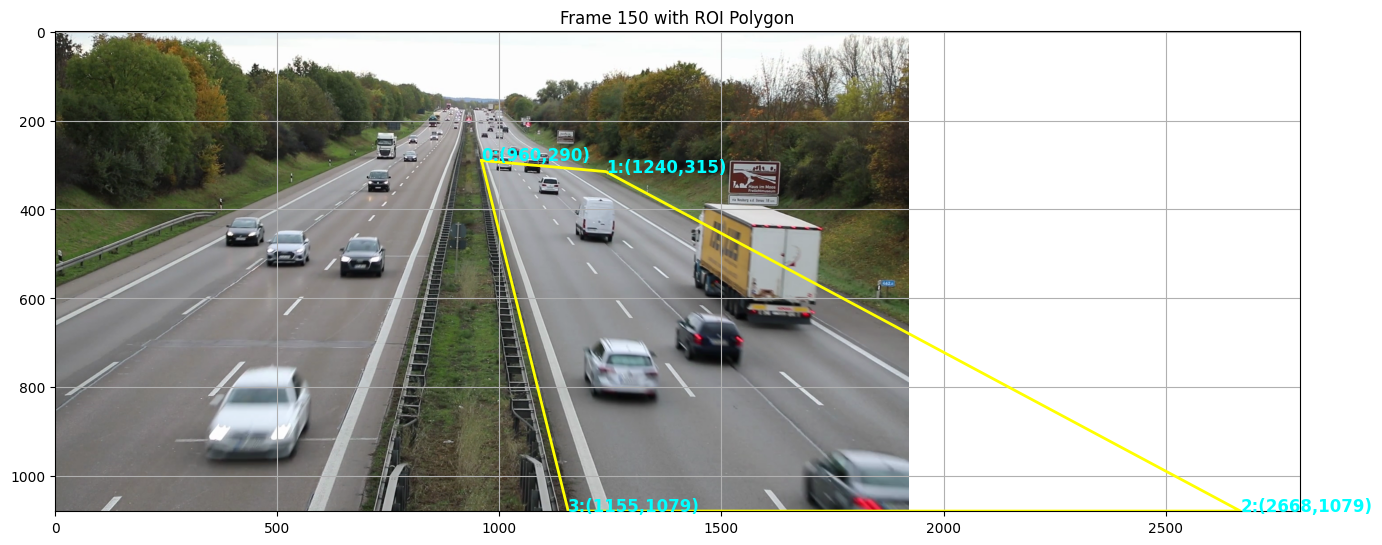

In [58]:
# --- ROI Visualization Test ---
# Load a single frame from video
video_path = './input_videos/cars_road_3.mp4'
cap = cv2.VideoCapture(video_path)
target_frame_number = 150
cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_number)
ret, frame = cap.read()
cap.release()
# Define the ROI polygon (adjust coordinates as needed)
roi_polygon = np.array([    [960, 290],
    [1240, 315],
    [2668, 1079],
    [1155, 1079]], np.int32)
if ret:
    # Convert BGR to RGB for plotting
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Plotting with matplotlib
    plt.figure(figsize=(14, 8))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {target_frame_number} with ROI Polygon")
    
    # Draw the polygon
    poly_closed = np.vstack([roi_polygon, roi_polygon[0]])  # Close the loop
    plt.plot(poly_closed[:, 0], poly_closed[:, 1], color='yellow', linewidth=2)

    # Optionally, label the vertices
    for idx, (x, y) in enumerate(roi_polygon):
        plt.text(x, y, f'{idx}:({x},{y})', color='cyan', fontsize=12, weight='bold')

    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Failed to read frame from video")

In [33]:
# Load the YOLOv8 model (using a standard pre-trained model)
# You might need to run '!pip install ultralytics' if you haven't already
model = YOLO('yolov8n.pt')  # Using yolov8n for speed, can change to yolov8s, yolov8m, etc. for better accuracy

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Could not open video file: {video_path}")
    # Handle error appropriately, maybe raise an exception
    raise FileNotFoundError(f"Video file not found or cannot be opened: {video_path}")
else:
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    # Calculate the number of frames for the first n seconds

        # Define the time range to process (in seconds)
    start_time = 5  # Start processing from 5 seconds into the video
    end_time = 15   # Process until 15 seconds into the video
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    frames_to_process =  end_frame - start_frame
    
    # Get total frame count for reference, but we'll stop early
    total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Video Properties - Resolution: {frame_width}x{frame_height}, FPS: {fps:.2f}, Total Frames: {total_frame_count}")
    print(start_frame, end_frame, frames_to_process)

    # Define the codec and create VideoWriter object (adjust output filename if desired)
    # output_video_path_trimmed = './output_videos/part3_detections_12s.mp4'
    # output_detections_path_trimmed = './output_data/part3_detections_12s.json'
    # Using original paths for now, will overwrite previous output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    # Store detections
    all_detections = {} # Dictionary to store detections per frame: {frame_idx: [detection1, detection2, ...]}

    frame_idx = 0

    # Skip to the start frame
    for _ in range(start_frame):
        ret = cap.read()[0]
        if not ret:
            print(f"\nEnd of video reached before start frame {start_frame}.")
            break
        frame_idx += 1

    while frame_idx < end_frame:            
        ret, frame = cap.read()
        if not ret:
            print(f"\nEnd of video reached or error reading frame {frame_idx+1} before reaching {frames_to_process} frames.")
            break

        # Perform inference
        results = model(frame, verbose=False, classes=[2, 5, 7]) 

        # Process results
        frame_detections = []
        if results:
            processed_result = results[0] 
            if processed_result.boxes is not None and len(processed_result.boxes) > 0:
                bboxes = processed_result.boxes.xyxy.cpu().numpy()
                confidences = processed_result.boxes.conf.cpu().numpy()
                classes = processed_result.boxes.cls.cpu().numpy()
                    
                for idx, bbox in enumerate(bboxes):
                    x1, y1, x2, y2 = map(int, bbox)
                    class_id = int(classes[idx])
                    confidence = float(confidences[idx])
                        
                    # Only add detections that are in the ROI
                    if is_in_roi([x1, y1, x2, y2], roi_polygon):
                        # Draw bounding box on frame (for visualization)
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        label = f"{class_id}: {confidence:.2f}"
                        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                            
                        # Add to detections list
                        frame_detections.append({
                            'bbox': [x1, y1, x2, y2],
                            'confidence': confidence,
                            'class_id': class_id
                        })
        
        # Draw ROI polygon on the frame
        cv2.polylines(frame, [roi_polygon.reshape(-1, 1, 2)], True, (0, 255, 255), 2)
        # Store detections for the current frame
        if frame_detections:
             all_detections[frame_idx] = frame_detections

        # Write the frame to the output video
        out.write(frame)

        # Optional: Display progress
        if (frame_idx - start_frame + 1) % 50 == 0 or frame_idx == start_frame:
            print(f"Processed frame {frame_idx} ({frame_idx - start_frame + 1}/{frames_to_process})")

        frame_idx += 1

    # Release everything when job is finished
    cap.release()
    out.release()
    print(f"Finished processing {frame_idx} frames. Output video saved to {output_video_path}")

    # Save detections to JSON file
    try:
        with open(output_detections_path, 'w') as f:
            json.dump(all_detections, f, indent=4)
        print(f"Detections saved to {output_detections_path}")
    except Exception as e:
        print(f"Error saving detections to JSON: {e}")

# Indicate completion
print(f"Part 3: Vehicle detection for seconds {start_time} to {end_time} complete.")


Video Properties - Resolution: 1920x1080, FPS: 25.00, Total Frames: 1060
125 375 250
Starting vehicle detection for the first 250 frames...
Processed frame 125 (1/250)
Processed frame 174 (50/250)
Processed frame 224 (100/250)
Processed frame 274 (150/250)
Processed frame 324 (200/250)
Processed frame 374 (250/250)
Finished processing 375 frames. Output video saved to ./output_videos/part3_detections.mp4
Detections saved to ./output_data/part3_detections.json
Part 3: Vehicle detection for seconds 5 to 15 complete.


## Tracking
tracking vehciles using the SORT algorithm

In [73]:
# %% [code]
from sort import Sort # Make sure sort.py is in the correct path or installed


# --- Configuration ---
output_online_sort_video_path = './output_videos/online_sort_tracking.mp4'
os.makedirs(os.path.dirname(output_online_sort_video_path), exist_ok=True)

output_track_history_path = './output_data/track_history.json' # Define output path for history
os.makedirs(os.path.dirname(output_track_history_path), exist_ok=True) # Ensure directory exists

# Use the ROI defined earlier
# roi_polygon = np.array([...], dtype=np.int32)

# Use the YOLO model loaded earlier
model = YOLO('yolov8n.pt') # Or the specific model loaded previously

score_threshold = 0.4 # Confidence threshold for detections fed to SORT
sort_max_age = 1      # Max frames to keep track without detection
sort_min_hits = 3     # Min consecutive hits to start track
sort_iou_threshold = 0.3 # IOU threshold for matching

start_time = 5  # in seconds
end_time = 20   # in seconds
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)
frames_to_process =  end_frame - start_frame

# --- Initialization ---
cap_online = cv2.VideoCapture(video_path)
if not cap_online.isOpened():
    print(f"Error: Could not open video file {video_path}")
else:

    frame_width = int(cap_online.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap_online.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap_online.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_online = cv2.VideoWriter(output_online_sort_video_path, fourcc, fps, (frame_width, frame_height))
    KalmanBoxTracker.count = 0
    # Initialize SORT tracker with parameters
    sort_tracker_online = Sort(max_age=sort_max_age, min_hits=sort_min_hits, iou_threshold=sort_iou_threshold)

    # Store trajectories (optional, for drawing lines)
    trajectories_online = {}
    track_colors = {} # Assign a random color to each track ID

    track_history = {} # Dictionary to store track history {track_id: [(frame_idx, bbox), ...]}
    
    frame_idx_online = 0
    start_time_proc = time.time()

    # --- Processing Loop ---

    # Skip to the start frame
    for _ in range(start_frame):
        ret = cap_online.read()[0]
        if not ret:
            print(f"\nEnd of video reached before start frame {start_frame}.")
            break
        frame_idx_online += 1
    while frame_idx_online < end_frame:
        ret, frame = cap_online.read()
        if not ret:
            print("\nEnd of video reached or error reading frame.")
            break

        # Perform YOLO inference
        results = model(frame, verbose=False) # verbose=False to reduce console spam

        detections_current_frame = []
        boxes = results[0].boxes.xyxy.cpu().numpy()
        scores = results[0].boxes.conf.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy().astype(int)

        for i in range(len(boxes)):
            # Filter by class and score threshold
            if  scores[i] >= score_threshold:
                x1, y1, x2, y2 = boxes[i]
                score = scores[i]
                # Format for SORT: [x1, y1, x2, y2, score]

                # --- ROI Filtering (Optional - apply before or after SORT) ---
                center_x = (x1 + x2) / 2
                bottom_y = y2 # Use bottom of box
                if cv2.pointPolygonTest(roi_polygon, (center_x, bottom_y), False) >= 0:
                     detections_current_frame.append([x1, y1, x2, y2, score])
                # detections_current_frame.append([x1, y1, x2, y2, score])

        # Update SORT tracker
        if len(detections_current_frame) > 0:
            tracked_objects = sort_tracker_online.update(np.array(detections_current_frame))
        else:
            # Provide empty array if no detections
            tracked_objects = sort_tracker_online.update(np.empty((0, 5)))



        # --- Visualization ---
        # Draw ROI
        cv2.polylines(frame, [roi_polygon], True, (0, 255, 255), 2) # Yellow ROI

        for track in tracked_objects:
            x1, y1, x2, y2, track_id = map(int, track)

            # --- Record Track History ---
            bbox = (x1, y1, x2, y2) # Current bounding box
            # Use frame_idx_online which should be tracking the current frame number in this loop
            frame_data = (frame_idx_online, bbox) # Data point: frame index and bbox
    
            if track_id not in track_history:
                track_history[track_id] = []
            track_history[track_id].append(frame_data)
            # --- End Record Track History ---
            
            # Assign color to new track ID
            if track_id not in track_colors:
                track_colors[track_id] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            color = track_colors[track_id]

            # Draw bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            label = f"ID: {track_id}"
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            # Update and draw trajectory (optional)
            center = (int((x1 + x2) / 2), int((y1 + y2) / 2))
            if track_id not in trajectories_online:
                trajectories_online[track_id] = []
            trajectories_online[track_id].append(center)

            # Draw last N points of trajectory
            if len(trajectories_online[track_id]) > 1:
                 # Limit trajectory length drawn to avoid clutter
                history_len = min(len(trajectories_online[track_id]), 50)
                for j in range(1, history_len):
                     idx = len(trajectories_online[track_id]) - j
                     pt1 = trajectories_online[track_id][idx - 1]
                     pt2 = trajectories_online[track_id][idx]
                     cv2.line(frame, pt1, pt2, color, 2)


        # Add frame counter
        cv2.putText(frame, f"Frame: {frame_idx_online}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Write frame to output video
        out_online.write(frame)

        frame_idx_online += 1

        # Display progress
        if frame_idx_online % 50 == 0:
            elapsed_time = time.time() - start_time_proc
            fps_proc = frame_idx_online / elapsed_time if elapsed_time > 0 else 0
            print(f"Processed frame {frame_idx_online} ({fps_proc:.2f} FPS)")


    # --- Cleanup ---
    cap_online.release()
    out_online.release()
    end_time_proc = time.time()
    total_time = end_time_proc - start_time_proc
    avg_fps = frame_idx_online / total_time if total_time > 0 else 0

    serializable_history = {}
    for tid, history in track_history.items():
         serializable_history[str(tid)] = [(int(f_idx), [int(coord) for coord in bb]) for f_idx, bb in history]

    with open(output_track_history_path, 'w') as f:
        json.dump(serializable_history, f, indent=4)
    print("Track history saved successfully.")

    print(f"\nFinished online SORT tracking.")
    print(f"Processed {frame_idx_online} frames in {total_time:.2f} seconds (Avg FPS: {avg_fps:.2f}).")
    print(f"Tracked video saved to {output_online_sort_video_path}")
    print(f"Total unique vehicle IDs tracked: {len(track_colors)}")


Processed frame 150 (90.31 FPS)
Processed frame 200 (45.62 FPS)
Processed frame 250 (35.64 FPS)
Processed frame 300 (31.83 FPS)
Processed frame 350 (29.60 FPS)
Processed frame 400 (27.85 FPS)
Processed frame 450 (26.92 FPS)
Processed frame 500 (26.24 FPS)
5
4
3
2
1
6
7
8
13
15
22
21
23
24
25
26
28
30
31
32
34
35
36
37
38
40
42
46
47
48
49
52
53
54
56
59
62
60
65
66
67
68
70
71
72
75
76
80
81
84
83
Track history saved successfully.

Finished online SORT tracking.
Processed 500 frames in 19.06 seconds (Avg FPS: 26.23).
Tracked video saved to ./output_videos/online_sort_tracking.mp4
Total unique vehicle IDs tracked: 51


##  Keypoint (Taillight) Detection

In [74]:
# --- Parameters ---
# HSV Color Range for Taillights (Red/Orange) - NEEDS TUNING!
# These are common ranges, but you MUST adjust them based on your video
# Hue range for red wraps around 0/180 in HSV
lower_red1 = np.array([0, 90, 90])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([165, 90, 90]) # Also adjust second range if used
upper_red2 = np.array([180, 255, 255])

# SimpleBlobDetector Parameters - NEEDS TUNING!
blob_params = cv2.SimpleBlobDetector_Params()
# Filter by Color (already done by HSV thresholding)
blob_params.filterByColor = False
# Filter by Area (adjust min/max based on expected taillight size in pixels)
blob_params.filterByArea = True
blob_params.minArea = 10  # Example: Minimum area in pixels
blob_params.maxArea = 500 # Example: Maximum area in pixels
# Filter by Circularity (taillights might be somewhat circular/oval)
blob_params.filterByCircularity = True
blob_params.minCircularity = 0.2 # Example
# Filter by Convexity (shape property)
blob_params.filterByConvexity = True
blob_params.minConvexity = 0.4 # Example
# Filter by Inertia (elongation, lower value means more elongated)
blob_params.filterByInertia = True
blob_params.minInertiaRatio = 0.05 # Example
blob_detector = cv2.SimpleBlobDetector_create(blob_params)

# Symmetry/Positioning Parameters - NEEDS TUNING!
# vertical_pos_threshold = 0.5 # Expect taillights in the bottom half (0.5) of the bbox height
horizontal_sym_tolerance = 0.3 # Allow deviation from perfect horizontal symmetry relative to bbox width

output_keypoint_history_path = './output_data/part5_keypoint_history.json'
os.makedirs(os.path.dirname(output_keypoint_history_path), exist_ok=True)

# --- Load Data ---
print(f"Loading track history from: {output_track_history_path}")
try:
    with open(output_track_history_path, 'r') as f:
        track_history = json.load(f)
    # Convert keys back to int if needed (depends on how it was saved)
    track_history = {int(k): v for k, v in track_history.items()}
    print(f"Loaded history for {len(track_history)} tracks.")
except FileNotFoundError:
    print(f"Error: Track history file not found at {output_track_history_path}")
    # Handle error appropriately, maybe raise exception or exit
    raise
except Exception as e:
    print(f"Error loading track history: {e}")
    raise

# --- Initialize ---
keypoint_history = {} # {track_id: [(frame_idx, left_kp, right_kp), ...]} left_kp/right_kp = (x, y) or None
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")
    raise FileNotFoundError(f"Video file not found or cannot be opened: {video_path}")

total_frames_to_process = sum(len(hist) for hist in track_history.values())
processed_frames_count = 0
start_time_kp = time.time()

print(f"Processing {total_frames_to_process} tracked bounding boxes...")

# --- Process Tracks ---
for track_id, history in track_history.items():
    keypoint_history[track_id] = []
    print(f"Processing Track ID: {track_id} ({len(history)} boxes)")

    for frame_idx, bbox in history:
        processed_frames_count += 1
        if processed_frames_count % 100 == 0:
             elapsed = time.time() - start_time_kp
             fps = processed_frames_count / elapsed if elapsed > 0 else 0
             print(f"  Processed {processed_frames_count}/{total_frames_to_process} boxes... ({fps:.2f} boxes/sec)")

        # Seek to the correct frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            print(f"  Warning: Could not read frame {frame_idx} for track {track_id}. Skipping.")
            keypoint_history[track_id].append((frame_idx, None, None))
            continue

        # Extract bounding box coordinates
        x1, y1, x2, y2 = map(int, bbox)

        # Ensure coordinates are valid
        if x1 >= x2 or y1 >= y2 or x1 < 0 or y1 < 0 or x2 > frame.shape[1] or y2 > frame.shape[0]:
             print(f"  Warning: Invalid bbox {bbox} at frame {frame_idx} for track {track_id}. Skipping.")
             keypoint_history[track_id].append((frame_idx, None, None))
             continue

        # Crop the frame to the bounding box
        crop = frame[y1:y2, x1:x2]
        if crop.size == 0:
            print(f"  Warning: Empty crop from bbox {bbox} at frame {frame_idx} for track {track_id}. Skipping.")
            keypoint_history[track_id].append((frame_idx, None, None))
            continue

        # --- Taillight Detection within Crop ---
        hsv_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)

        # Apply HSV thresholding (combine masks for wrapped red hue)
        mask1 = cv2.inRange(hsv_crop, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv_crop, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask1, mask2)

        # Optional: Morphological operations to clean mask
        # kernel = np.ones((3,3), np.uint8)
        # mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        # mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Detect blobs
        keypoints = blob_detector.detect(mask)

        # --- Filter blobs to find likely taillight pair ---
        left_kp, right_kp = None, None
        potential_kps = []
        crop_h, crop_w = crop.shape[:2]
        crop_center_x = crop_w / 2

        # Filter blobs by vertical position and store coordinates relative to full frame
        for kp in keypoints:
            kp_x_crop, kp_y_crop = kp.pt
            if kp_y_crop > crop_h * vertical_pos_threshold: # Check if in lower part
                # Convert keypoint coordinates from crop-relative to frame-relative
                kp_x_frame = x1 + kp_x_crop
                kp_y_frame = y1 + kp_y_crop
                potential_kps.append(((kp_x_frame, kp_y_frame), kp_x_crop)) # Store frame coords and crop x-coord for symmetry check

        # Look for a symmetrical pair
        if len(potential_kps) >= 2:
            best_pair = None
            min_sym_error = float('inf')

            # Iterate through all pairs (simple O(n^2) approach)
            for i in range(len(potential_kps)):
                for j in range(i + 1, len(potential_kps)):
                    kp1_frame, kp1_x_crop = potential_kps[i]
                    kp2_frame, kp2_x_crop = potential_kps[j]

                    # Check horizontal symmetry within tolerance
                    center_diff1 = abs(kp1_x_crop - crop_center_x)
                    center_diff2 = abs(kp2_x_crop - crop_center_x)
                    symmetry_error = abs(center_diff1 - center_diff2) / crop_w

                    if symmetry_error < horizontal_sym_tolerance:
                        # Check vertical alignment (optional, could add tolerance here too)
                        # if abs(kp1_frame[1] - kp2_frame[1]) < vertical_alignment_tolerance:
                            if symmetry_error < min_sym_error: # Find the most symmetrical pair
                                min_sym_error = symmetry_error
                                # Assign left/right based on x-coordinate in the crop
                                if kp1_x_crop < kp2_x_crop:
                                    best_pair = (kp1_frame, kp2_frame)
                                else:
                                    best_pair = (kp2_frame, kp1_frame)

            if best_pair:
                left_kp, right_kp = best_pair

        # Store results for this frame
        keypoint_history[track_id].append((frame_idx, left_kp, right_kp))

# --- Cleanup ---
cap.release()
end_time_kp = time.time()
total_time_kp = end_time_kp - start_time_kp
avg_fps_kp = processed_frames_count / total_time_kp if total_time_kp > 0 else 0

print(f"\n--- Finished Keypoint Detection ---")
print(f"Processed {processed_frames_count} boxes in {total_time_kp:.2f} seconds (Avg: {avg_fps_kp:.2f} boxes/sec).")

# --- Save Keypoint History ---
print(f"Saving keypoint history to {output_keypoint_history_path}...")
try:
    # Convert tuples to lists for JSON serialization
    serializable_kp_history = {}
    for tid, history in keypoint_history.items():
        serializable_kp_history[str(tid)] = []
        for f_idx, l_kp, r_kp in history:
            l_kp_list = list(map(int, l_kp)) if l_kp else None
            r_kp_list = list(map(int, r_kp)) if r_kp else None
            serializable_kp_history[str(tid)].append([int(f_idx), l_kp_list, r_kp_list])

    with open(output_keypoint_history_path, 'w') as f:
        json.dump(serializable_kp_history, f, indent=4)
    print("Keypoint history saved successfully.")
except Exception as e:
    print(f"Error saving keypoint history: {e}")


# You can now optionally add visualization code here or in a new cell
# to load the keypoint history and draw the points on sample frames.

Loading track history from: ./output_data/track_history.json
Loaded history for 51 tracks.
Processing 2222 tracked bounding boxes...
Processing Track ID: 5 (11 boxes)
Processing Track ID: 4 (14 boxes)
Processing Track ID: 3 (20 boxes)
Processing Track ID: 2 (55 boxes)
  Processed 100/2222 boxes... (4.68 boxes/sec)
Processing Track ID: 1 (50 boxes)
Processing Track ID: 6 (83 boxes)
  Processed 200/2222 boxes... (4.51 boxes/sec)
Processing Track ID: 7 (19 boxes)
Processing Track ID: 8 (68 boxes)
  Processed 300/2222 boxes... (4.23 boxes/sec)
Processing Track ID: 13 (87 boxes)
  Processed 400/2222 boxes... (3.95 boxes/sec)
Processing Track ID: 15 (23 boxes)
Processing Track ID: 22 (37 boxes)
Processing Track ID: 21 (28 boxes)
Processing Track ID: 23 (49 boxes)
  Processed 500/2222 boxes... (3.78 boxes/sec)
Processing Track ID: 24 (7 boxes)
Processing Track ID: 25 (3 boxes)
Processing Track ID: 26 (15 boxes)
Processing Track ID: 28 (157 boxes)
  Processed 600/2222 boxes... (3.63 boxes/sec)

--- Starting Corrected Keypoint Sequence Verification Visualization (v3) ---
Loading keypoint history...
Loaded keypoint history for 51 tracks.
Loading track (bounding box) history...
Loaded bounding box history for 51 tracks.

Searching for sequences (length=3) meeting CORRECTED criteria...
Criteria: Y_align_diff <= 15, 20 <= X_dist <= 150, frame_gap <= 1

Found 137 total valid sequences meeting corrected criteria.
Visualizing 9 sequences from unique cars...


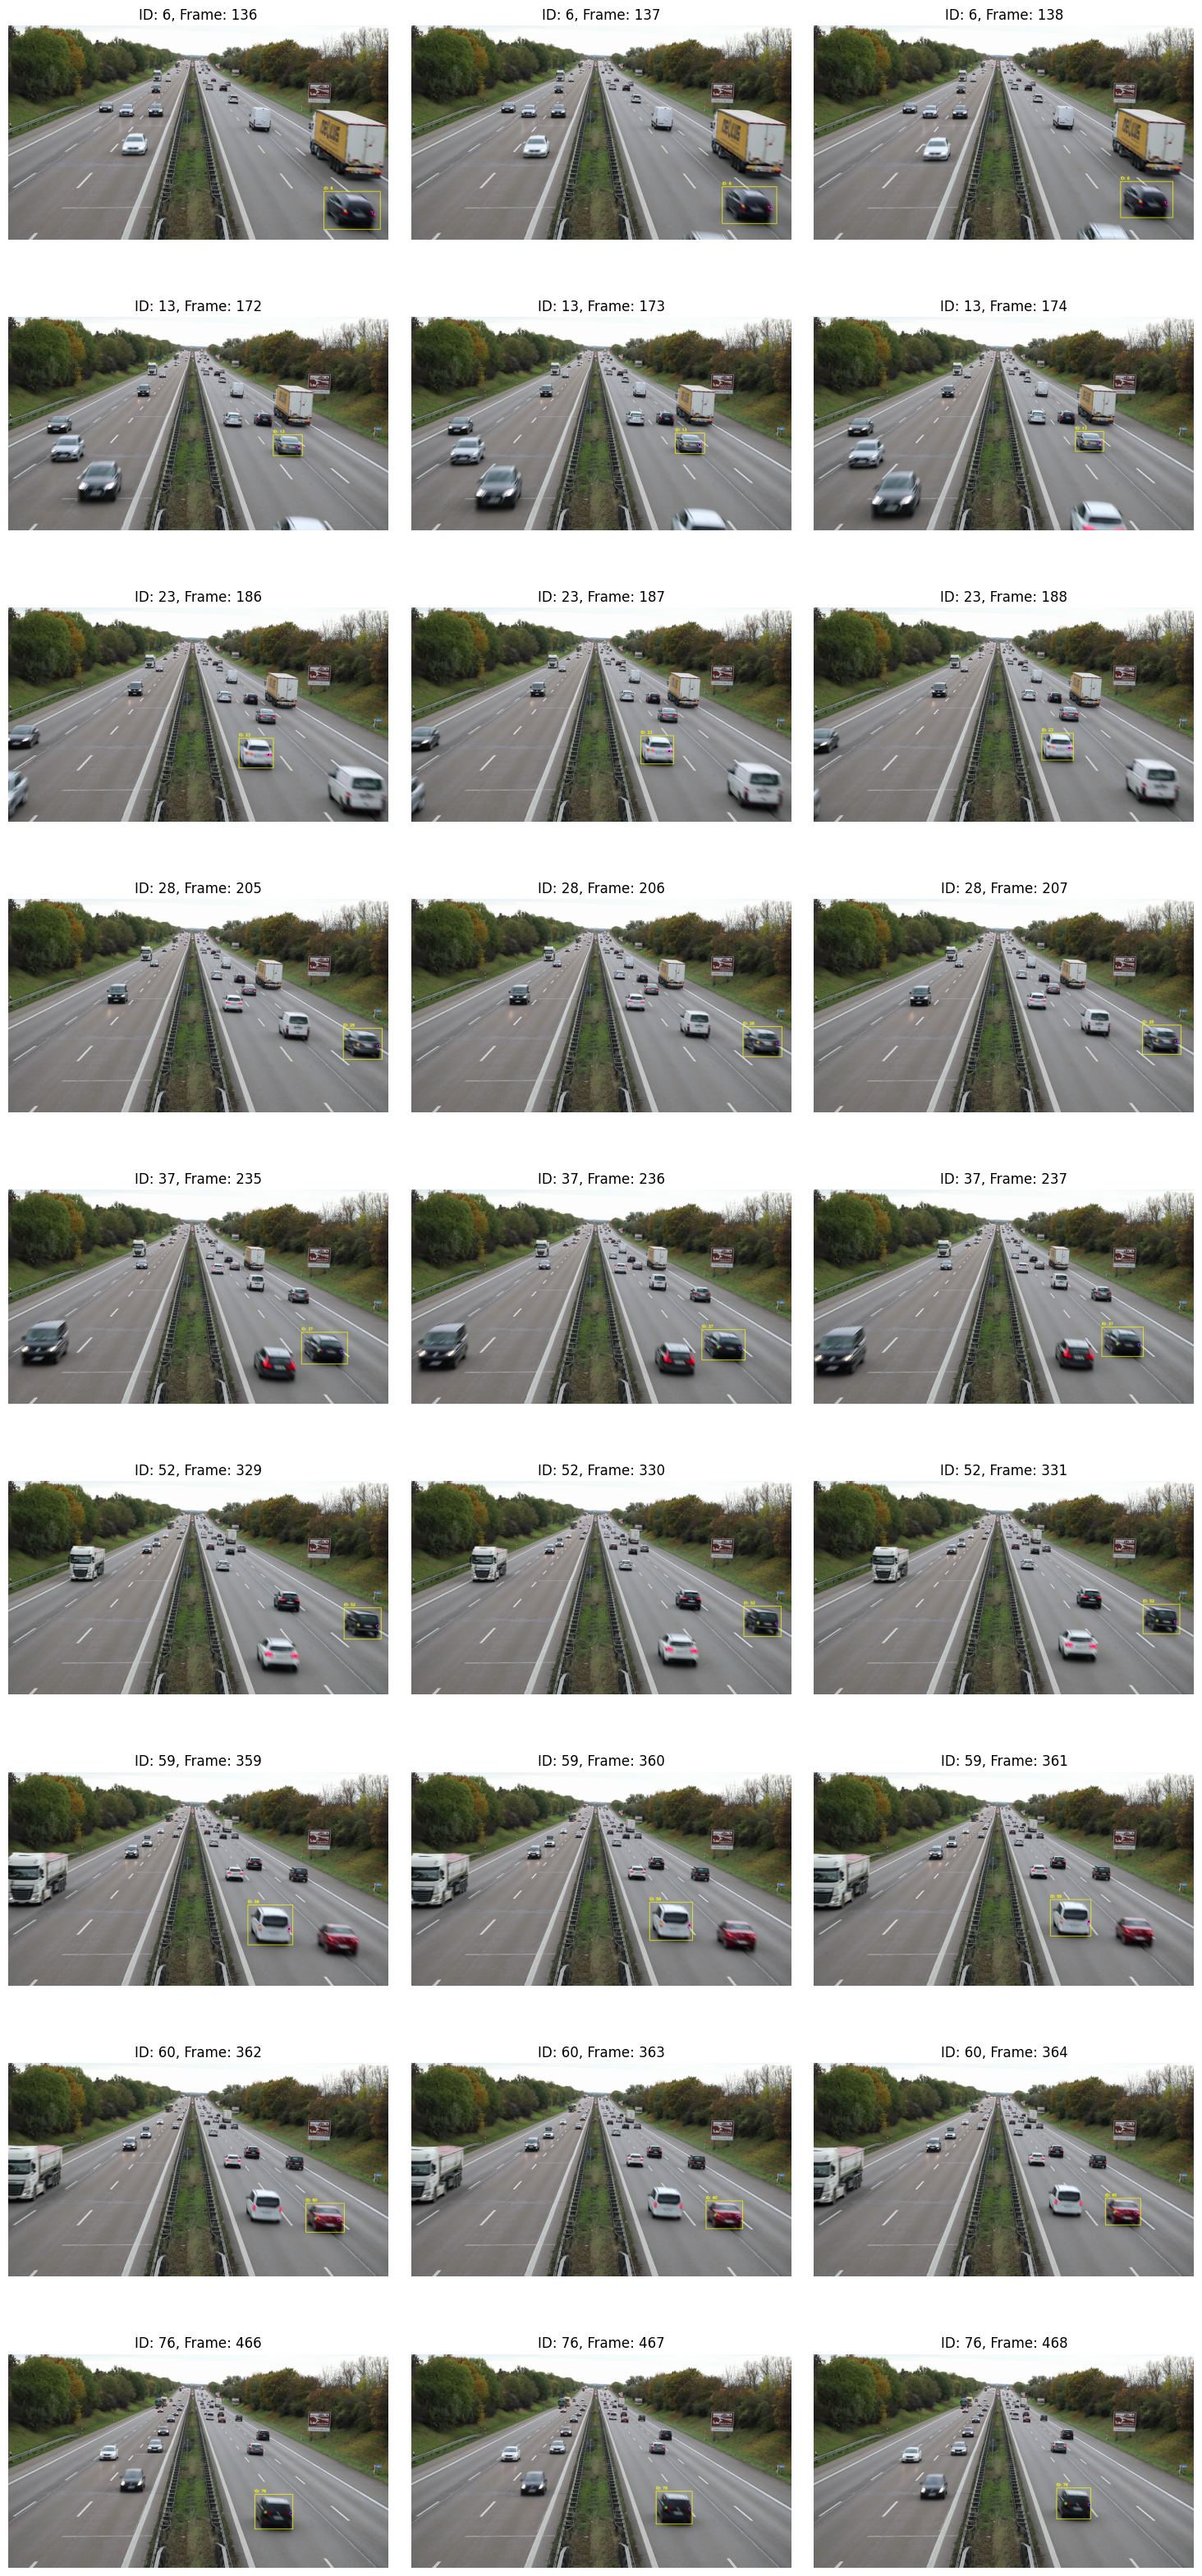


--- Corrected Sequence Verification Visualization Complete ---


In [13]:
import cv2
import numpy as np
import json
import random
import matplotlib.pyplot as plt
import os

print("--- Starting Corrected Keypoint Sequence Verification Visualization (v3) ---")

# --- Parameters ---
sequence_length_to_show = 3
num_sequences_to_visualize = 10 # Max unique cars to try and show
max_frame_gap = 1

# Y-Axis Alignment Parameters (Checking vertical alignment)
max_vertical_alignment_diff_pixels = 15 # Max allowed Y difference between L/R points

# X-Axis Distance Parameters (Checking horizontal separation)
min_horizontal_distance_pixels = 20  # Min allowed X difference (avoid stacking/overlap)
max_horizontal_distance_pixels = 150 # Max allowed X difference (avoid points being too far apart)

# Colors and Appearance
keypoint_color_left = (0, 255, 0)   # Green (BGR)
keypoint_color_right = (255, 0, 0)  # Blue (BGR)
bbox_color = (0, 255, 255)          # Yellow (BGR)
keypoint_radius = 5

output_keypoint_history_path = './output_data/part5_keypoint_history.json'
output_track_history_path = './output_data/track_history.json'
video_path = './input_videos/cars_road_3.mp4'

# --- Load Data ---
print("Loading keypoint history...")
try:
    with open(output_keypoint_history_path, 'r') as f:
        keypoint_history_raw = json.load(f)
    keypoint_history = {}
    for tid_str, history_list in keypoint_history_raw.items():
        tid = int(tid_str)
        keypoint_history[tid] = {}
        for item in history_list:
            frame_idx = item[0]
            lkp = tuple(item[1]) if item[1] else None
            rkp = tuple(item[2]) if item[2] else None
            keypoint_history[tid][frame_idx] = {'lkp': lkp, 'rkp': rkp}
    print(f"Loaded keypoint history for {len(keypoint_history)} tracks.")
except FileNotFoundError:
    print(f"Error: Keypoint history file not found at {output_keypoint_history_path}")
    # raise # Consider commenting out raise during debugging if file might be missing temporarily
    exit()
except Exception as e:
    print(f"Error loading keypoint history: {e}")
    raise

print("Loading track (bounding box) history...")
try:
    with open(output_track_history_path, 'r') as f:
        track_history_raw = json.load(f)
    track_history = {}
    for tid_str, history_list in track_history_raw.items():
        tid = int(tid_str)
        track_history[tid] = {}
        for item in history_list:
            track_history[tid][item[0]] = tuple(item[1]) # bbox
    print(f"Loaded bounding box history for {len(track_history)} tracks.")
except FileNotFoundError:
    print(f"Error: Bounding box history file not found at {output_track_history_path}")
    # raise # Consider commenting out raise during debugging
    exit()
except Exception as e:
    print(f"Error loading bounding box history: {e}")
    raise


# --- Prepare Video Capture ---
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")
    raise FileNotFoundError(f"Video file not found or cannot be opened: {video_path}")

# --- Find Qualifying Sequences ---
valid_sequences = []
print(f"\nSearching for sequences (length={sequence_length_to_show}) meeting CORRECTED criteria...")
print(f"Criteria: Y_align_diff <= {max_vertical_alignment_diff_pixels}, {min_horizontal_distance_pixels} <= X_dist <= {max_horizontal_distance_pixels}, frame_gap <= {max_frame_gap}")

for track_id, frame_data in keypoint_history.items():
    if track_id not in track_history:
        continue
    sorted_frame_indices = sorted(frame_data.keys())
    for i in range(len(sorted_frame_indices) - sequence_length_to_show + 1):
        is_valid_sequence = True
        sequence_frames = []
        for j in range(sequence_length_to_show):
            current_frame_idx = sorted_frame_indices[i+j]
            if current_frame_idx not in frame_data:
                 is_valid_sequence = False
                 break
            kps = frame_data[current_frame_idx]
            left_kp = kps['lkp']
            right_kp = kps['rkp']

            # 1. Both keypoints detected
            if left_kp is None or right_kp is None:
                is_valid_sequence = False
                break

            # Calculate differences
            vertical_alignment_diff = abs(left_kp[1] - right_kp[1]) # Y difference
            horizontal_distance = abs(left_kp[0] - right_kp[0])     # X difference

            # 2. Check Y-Axis Alignment (should be small)
            if vertical_alignment_diff > max_vertical_alignment_diff_pixels:
                is_valid_sequence = False
                break

            # 3. Check X-Axis Distance (should be within range)
            if not (min_horizontal_distance_pixels <= horizontal_distance <= max_horizontal_distance_pixels):
                is_valid_sequence = False
                break

            # 4. Check frame consecutiveness
            if j > 0:
                prev_frame_idx = sorted_frame_indices[i+j-1]
                if not (0 < (current_frame_idx - prev_frame_idx) <= max_frame_gap):
                    is_valid_sequence = False
                    break

            sequence_frames.append(current_frame_idx)

        # If the whole sequence was valid
        if is_valid_sequence:
            bbox_data_available = all(f_idx in track_history[track_id] for f_idx in sequence_frames)
            if bbox_data_available:
                valid_sequences.append({
                    'track_id': track_id,
                    'start_frame': sequence_frames[0],
                    'frames': sequence_frames
                })

if not valid_sequences:
    print("\nWarning: No sequences meeting the corrected criteria were found.")
    print("Consider adjusting criteria (alignment/distance tolerances, frame gap) or improving keypoint detection.")
else:
    print(f"\nFound {len(valid_sequences)} total valid sequences meeting corrected criteria.")

    # --- Ensure unique cars for visualization ---
    unique_sequences_by_tid = {}
    for seq in valid_sequences:
        tid = seq['track_id']
        if tid not in unique_sequences_by_tid:
            unique_sequences_by_tid[tid] = seq
        if len(unique_sequences_by_tid) >= num_sequences_to_visualize:
            break

    selected_sequences = list(unique_sequences_by_tid.values())

    if not selected_sequences:
         print("No valid sequences found to visualize after filtering for unique cars.")
    else:
        num_to_show = len(selected_sequences)
        print(f"Visualizing {num_to_show} sequences from unique cars...")

        # --- Visualize ---
        plt.figure(figsize=(15, num_to_show * (sequence_length_to_show * 1.2)))
        plot_idx_overall = 1
        for i, seq_info in enumerate(selected_sequences):
            track_id = seq_info['track_id']
            frame_indices = seq_info['frames']

            for j, frame_idx in enumerate(frame_indices):
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if not ret:
                    print(f"  Warning: Could not read frame {frame_idx}. Skipping.")
                    continue

                kps = keypoint_history[track_id][frame_idx]
                bbox = track_history[track_id][frame_idx]
                left_kp = kps['lkp']
                right_kp = kps['rkp']

                x1, y1, x2, y2 = map(int, bbox)
                cv2.rectangle(frame, (x1, y1), (x2, y2), bbox_color, 2)
                cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, bbox_color, 2)

                if left_kp:
                    center_left = tuple(map(int, left_kp))
                    cv2.circle(frame, center_left, keypoint_radius, keypoint_color_left, -1)
                    cv2.circle(frame, center_left, keypoint_radius + 2, (255,255,255), 1)

                if right_kp:
                    center_right = tuple(map(int, right_kp))
                    cv2.circle(frame, center_right, keypoint_radius, keypoint_color_right, -1)
                    cv2.circle(frame, center_right, keypoint_radius + 2, (255,255,255), 1)

                plt.subplot(num_to_show, sequence_length_to_show, plot_idx_overall)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f"ID: {track_id}, Frame: {frame_idx}")
                plt.axis('off')
                plot_idx_overall += 1

        plt.tight_layout(pad=2.0)
        plt.show()

# --- Cleanup ---
cap.release()
print("\n--- Corrected Sequence Verification Visualization Complete ---")